In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import os
#change to desired path
os.chdir("./drive/MyDrive/Research")
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Research'

In [2]:
%pip install torch datasets transformers tqdm matplotlib

In [3]:
import os
import time
import math

import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

from utils import set_seed, setup_logging, CfgNode as CN
from trainer import Trainer
from model import GPT

from datasets import load_dataset
from transformers import GPT2TokenizerFast
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
class TextbookDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # Get a block of text data
        chunk = self.data[idx:idx + self.block_size + 1]
        # Convert list of integers to tensors
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)
        return x, y

In [5]:
def load_textbooks(block_size, tokenizer):
    # Load and tokenize dataset
    dataset = load_dataset('AiresPucrs/stanford-encyclopedia-philosophy', split='train')

    def tokenize(examples):
        # Convert text to a flat list of token ids
        return {'input_ids': tokenizer(examples['text'], add_special_tokens=False)['input_ids']}

    dataset = dataset.map(tokenize, batched=True, num_proc=4, remove_columns=['text'])
    dataset.set_format(type='torch', columns=['input_ids'])  # Ensure dataset is in torch format

    # Flatten the list of token ids for proper indexing
    flattened_data = [token_id for sublist in dataset['input_ids'] for token_id in sublist]

    # Create the WikitextDataset
    train_dataset = TextbookDataset(flattened_data, block_size)
    return train_dataset

In [6]:
def run_training(trainer, total_iters, early_stop_threshold):
    # Initialize tqdm progress bar
    pbar = tqdm(total=total_iters, desc="Training progress", leave=True)

    train_losses = []  # List to store training losses for plotting
    best_loss = float('inf')
    no_improve_count = 0

    def update_progress(trainer):
        """Callback function to update progress and display loss after each iteration."""
        # Update the progress bar by one step
        pbar.update(1)
        current_loss = trainer.loss.item()
        train_losses.append(current_loss)  # Track loss for plotting
        pbar.set_postfix_str(f"Loss: {current_loss:.4f}")

        # Early stopping logic
        nonlocal best_loss, no_improve_count
        if current_loss < best_loss:
            best_loss = current_loss
            no_improve_count = 0
        else:
            no_improve_count += 1
        if no_improve_count >= early_stop_threshold:
            pbar.close()  # Close the progress bar when stopping early
            raise StopIteration("Early stopping triggered")

    # Attach the progress updating callback
    trainer.add_callback('on_batch_end', update_progress)

    try:
        # Start the training
        trainer.run()
    except StopIteration as e:
        print(str(e))
    finally:
        # Ensure the progress bar closes correctly
        try:
            pbar.close()
        except:
            pass  # Ignore any error in closing the progress bar

    return train_losses  # Return the list of training losses

In [10]:
C = CN()
C.system = CN()
C.system.work_dir = './out/wikitext'
setup_logging(C)

C.model = GPT.get_default_config()
C.model.model_type = None
C.model.n_layer = 2
C.model.n_head = 2
C.model.n_embd =  128
C.model.vocab_size = 50257
C.model.block_size = 128

C.trainer = Trainer.get_default_config()
C.trainer.learning_rate = 5e-4
C.trainer.max_iters = 10000

model_path = os.path.join(C.system.work_dir, 'model.pt')
early_stop_threshold = 50

In [11]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
model = GPT(C.model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


number of parameters: 14.32M


In [12]:
train_dataset = load_textbooks(C.model.block_size, tokenizer)
trainer = Trainer(C.trainer, model, train_dataset)
losses = run_training(trainer, C.trainer.max_iters, early_stop_threshold)

running on device cuda


Training progress:   6%|▌         | 571/10000 [10:33<2:54:27,  1.11s/it, Loss: 5.6596]


Early stopping triggered


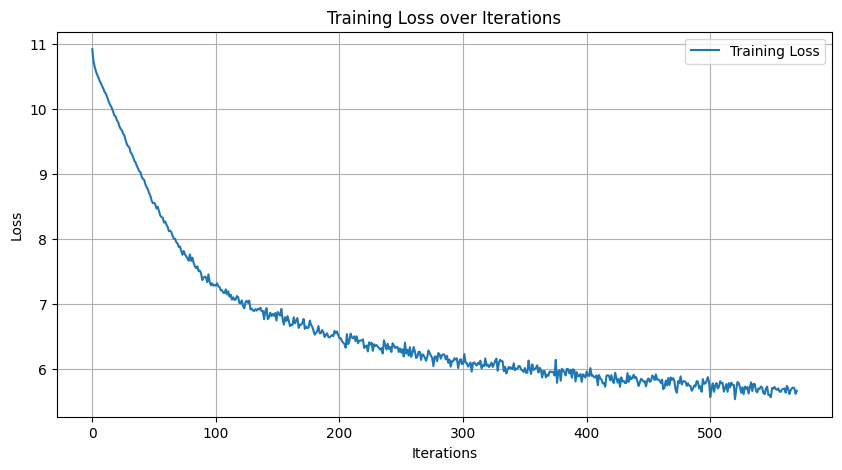

In [13]:
# Plot training loss after training
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./out/wikitext/model.pt


In [27]:
model = GPT(C.model)
model.load_state_dict(torch.load(model_path))
model.eval()
input_phrase = "The start"
input_ids = tokenizer.encode(input_phrase, return_tensors='pt')
with torch.no_grad():
    output = model.generate(input_ids, max_new_tokens=50, temperature=0.8, do_sample=True)
generated_text = tokenizer.decode(output[0])
print(f"Generated text: {generated_text}")

number of parameters: 14.32M
Generated text: The start of the benefit of that has of a number of this is an agent’s own authority of only if the essay to be a way. The soul is also formal literature that this work. All of such as a matter, if the same theory
